In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols
import plotly.express as px
from scipy.optimize import minimize

# Why Mix Market Modelling?

## In comparison to DiD, MMM has a few specific advantages and could be a supporting or alternative impact measurement framework. In the case of the task at hand I would still recommend using DiD first, yet MMM could prove useful.

### In terms of a company like Bolt that uses several marketing channels (eg. mentioned in the task Snapchat) MMM could be a good choice still:

- Big Picture: MMM looks at multiple marketing channels at once, letting us assess TweetX's impact within Bolt's entire marketing mix.
- Long-Term Effects: Unlike DiD, which focuses on immediate impact, MMM can capture both short-term and long-term effects of the TweetX campaign.
- Considers External Factors: MMM can include variables like weather, events, or economic indicators, giving a fuller understanding of what drives ride numbers.
- Diminishing Returns: MMM can capture non-linear relationships, such as diminishing returns on ad spend, which is crucial for optimizing the TweetX budget.
- Channel Interactions: MMM can model how TweetX interacts with other marketing channels, providing insights into synergies or cannibalization effects.


# An example of how a campaign impact using this framework could be measured (some features included in the model are temprature and weekend just as an example):

- In this example I assume we only run the tweetX campaign for Poznan and Wroclaw


Model summary:
Intercept         1.816195e+03
snapchat_spend   -5.551115e-17
facebook_spend    0.000000e+00
google_spend      1.329500e+00
temperature      -1.621217e+01
is_weekend        4.212973e+02
dtype: float64


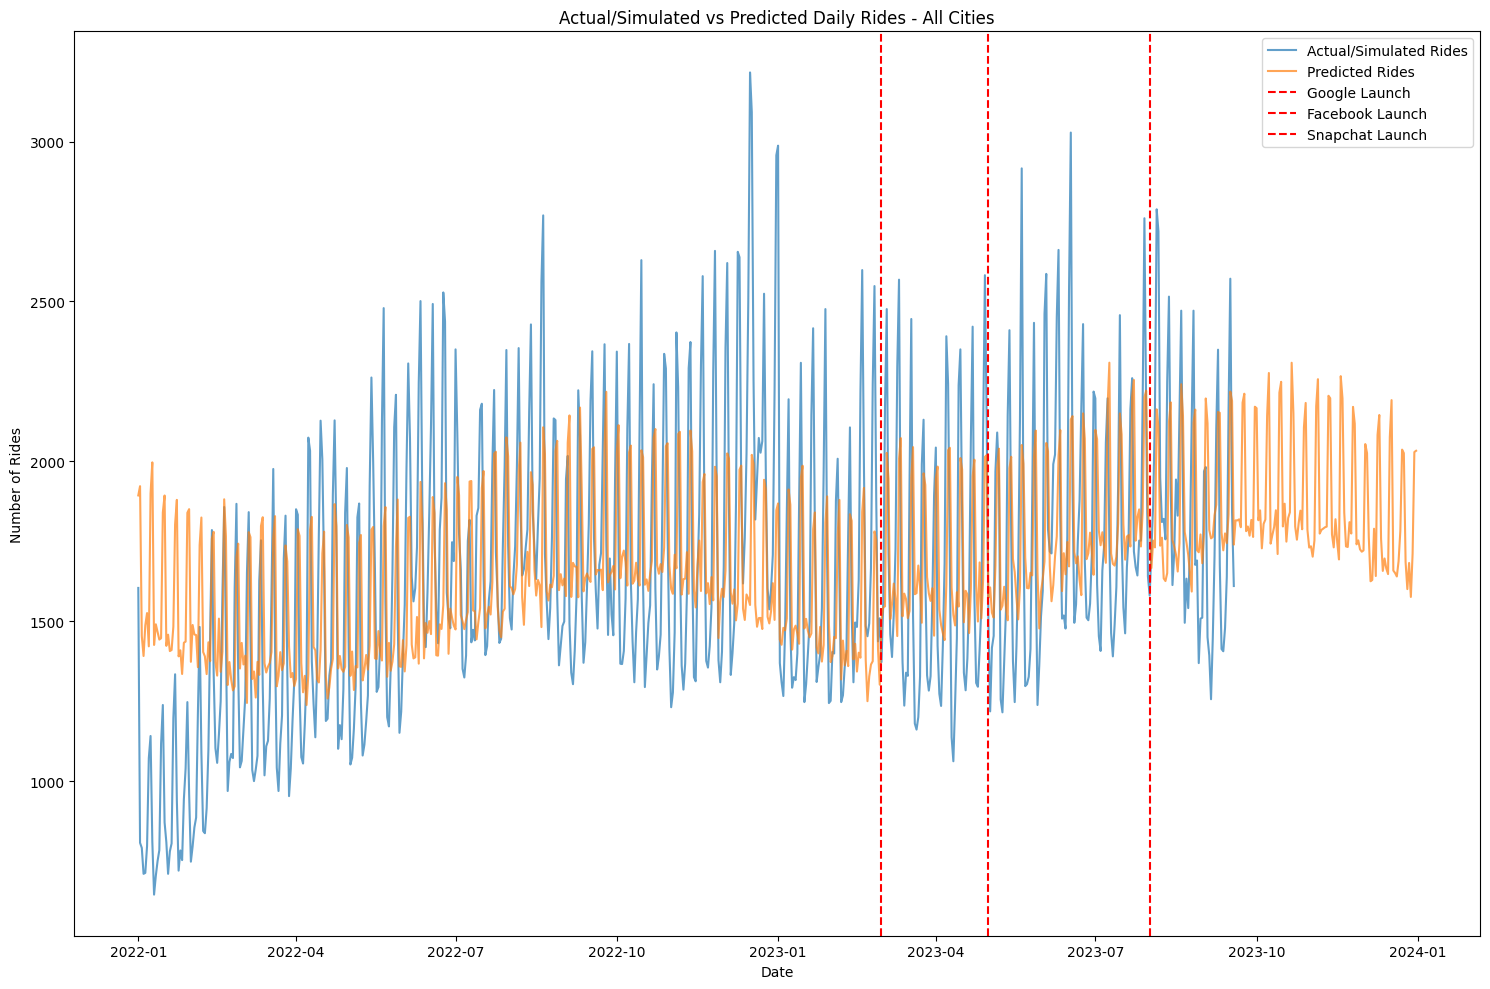

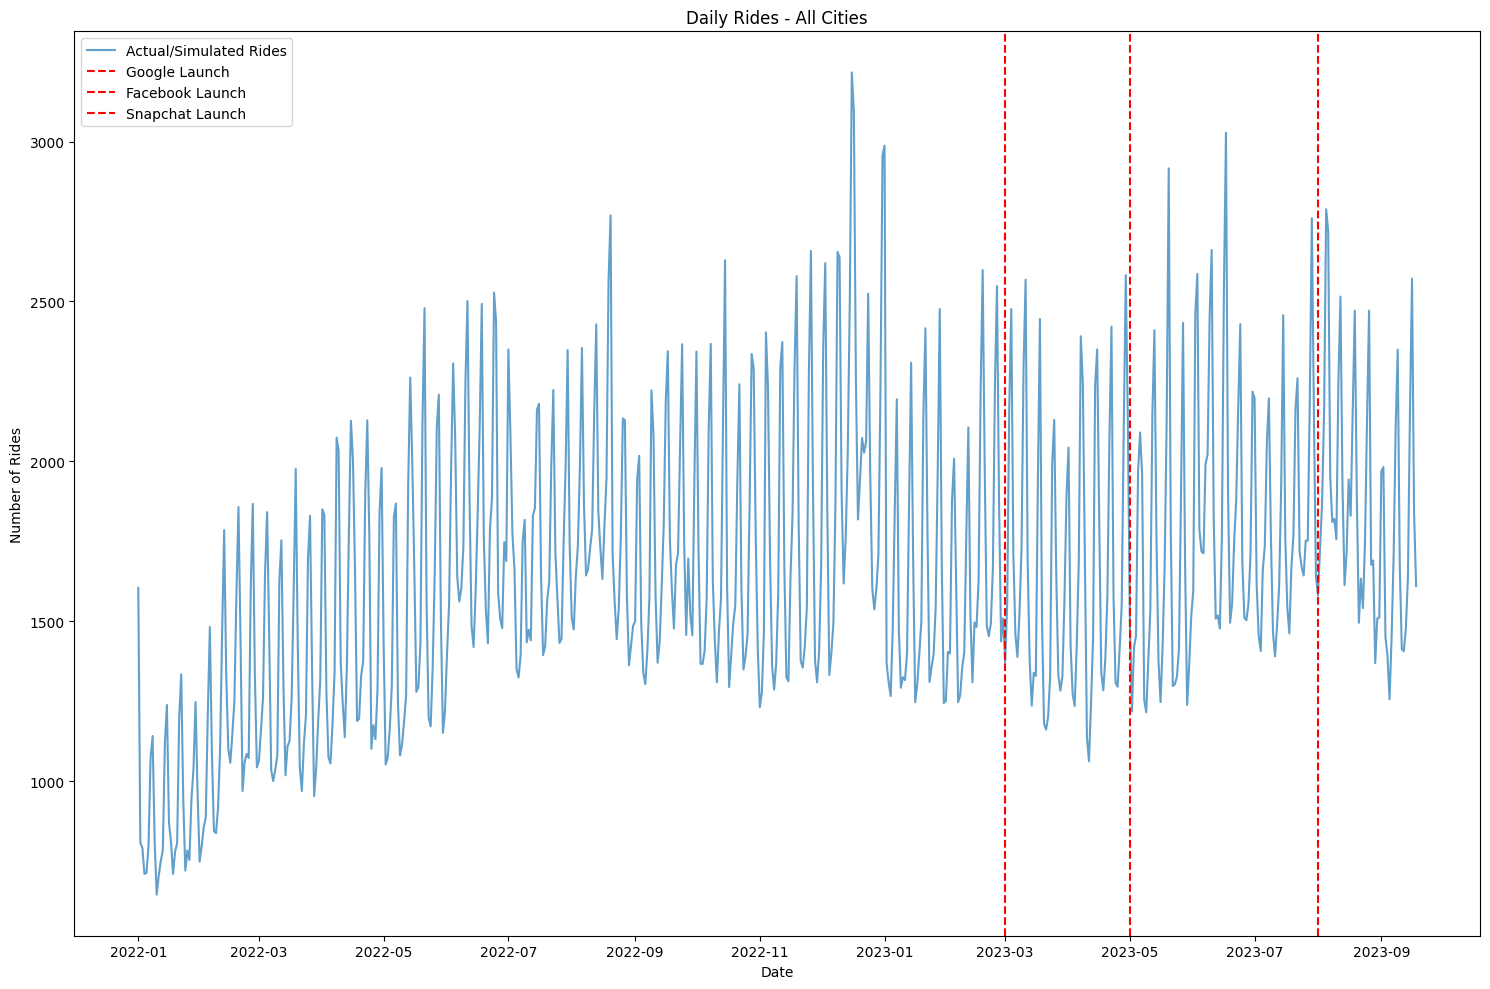

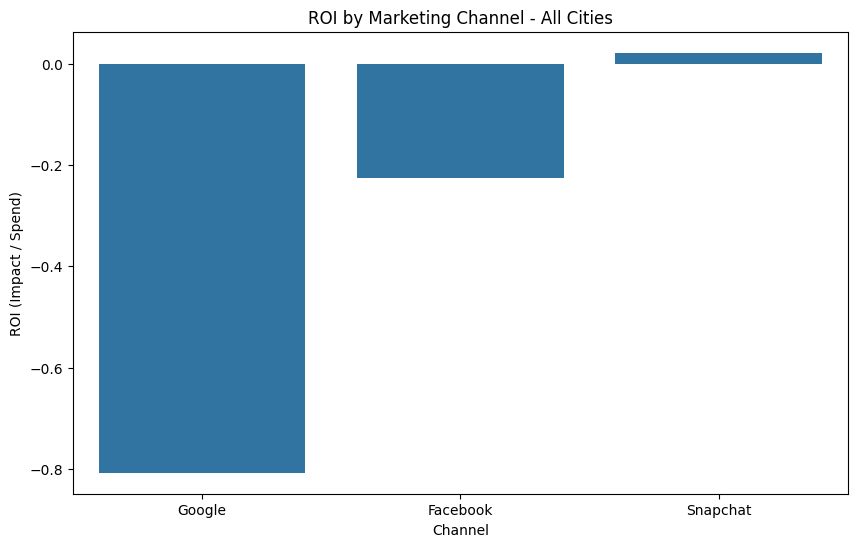


Marketing Channel Impacts:
Google:
  Total Spend: €4,996
  Estimated Impact (Adjusted for Seasonality): -4,032 additional rides
  ROI: -0.81
  Change This Year: -22
  Change Last Year: 112
  Difference: -134
Facebook:
  Total Spend: €5,094
  Estimated Impact (Adjusted for Seasonality): -1,148 additional rides
  ROI: -0.23
  Change This Year: -32
  Change Last Year: 6
  Difference: -38
Snapchat:
  Total Spend: €4,946
  Estimated Impact (Adjusted for Seasonality): 106 additional rides
  ROI: 0.02
  Change This Year: 121
  Change Last Year: 118
  Difference: 4

Estimated Snapchat Impact: 106 additional rides over 30 days


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import minimize

# get the data fromt the csv file
df = pd.read_csv(r'C:\Users\kaczm\Desktop\Bolt Marketing\Test Task - Marketing Measurement - DF.csv')
df['date'] = pd.to_datetime(df['date'])
cities = ['Poznan', 'Wroclaw']
df['total_rides'] = df[cities].sum(axis=1)

# a function that predict future rides for a given city
def predict_future_rides(ride_data, steps):
    decomposition = seasonal_decompose(ride_data, model='additive', period=7)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    trend_change = np.mean(np.diff(trend.dropna()))
    future_trend = np.arange(1, steps+1) * trend_change + trend.iloc[-1]
    future_seasonal = np.tile(seasonal[-7:], (steps // 7) + 1)[:steps]
    return future_trend + future_seasonal

last_date = df['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), end='2023-12-31')
steps = len(future_dates)

future_rides = predict_future_rides(df['total_rides'], steps)
df_future = pd.DataFrame({'date': future_dates, 'total_rides': future_rides})

df_combined = pd.concat([df[['date', 'total_rides']], df_future]).reset_index(drop=True)


np.random.seed(42)
channel_start_dates = {
    'google': '2023-03-01',
    'facebook': '2023-05-01',
    'snapchat': '2023-08-01'  # snapchat campaign started in August 2023 as we got informed in the task
}

for channel, start_date in channel_start_dates.items():
    column_name = f'{channel}_spend'
    df_combined[column_name] = np.where(df_combined['date'] >= start_date, 
                                        np.random.uniform(4000, 6000, len(df_combined)) / 30, 0)

# some additional features for the model to make it more interesting and realistic
df_combined['temperature'] = 20 + 10 * np.sin(np.arange(len(df_combined)) * 2 * np.pi / 365) + np.random.normal(0, 3, len(df_combined))
df_combined['is_weekend'] = (df_combined['date'].dt.dayofweek >= 5).astype(int)

# simulate
for channel, start_date in channel_start_dates.items():
    channel_mask = df_combined['date'] >= start_date


def constrained_ols(formula, data):
    model = ols(formula, data).fit()
    
    def obj_func(params):
        return -model.llf  
    
    spend_vars = [var for var in model.params.index if 'spend' in var]
    constraints = [{'type': 'ineq', 'fun': lambda params, i=i: params[i]} for i, var in enumerate(model.params.index) if var in spend_vars]
    
    initial = model.params.values
    result = minimize(obj_func, initial, method='SLSQP', constraints=constraints)
    
    constrained_model = ols(formula, data).fit()
    constrained_model.params = pd.Series(result.x, index=model.params.index)
    
    return constrained_model

formula = "total_rides ~ snapchat_spend + facebook_spend + google_spend + temperature + is_weekend"
model = constrained_ols(formula, df_combined)
print("\nModel summary:")
print(model.params)

# visualize
plt.figure(figsize=(15, 10))
df_combined['predicted_rides'] = model.predict(df_combined)
plt.plot(df_combined['date'], df_combined['total_rides'], label='Actual/Simulated Rides', alpha=0.7)
plt.plot(df_combined['date'], df_combined['predicted_rides'], label='Predicted Rides', alpha=0.7)
for channel, start_date in channel_start_dates.items():
    plt.axvline(x=pd.to_datetime(start_date), color='r', linestyle='--', label=f'{channel.capitalize()} Launch')
plt.legend()
plt.title('Actual/Simulated vs Predicted Daily Rides - All Cities')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.tight_layout()
plt.show()

def calculate_campaign_impact(df, channel, start_date):
    campaign_start = pd.to_datetime(start_date)
    campaign_end = campaign_start + pd.Timedelta(days=30)
    
    # we need to adjust the result vs previosu year 
    pre_campaign = df[(df['date'] >= campaign_start - pd.Timedelta(days=30)) & (df['date'] < campaign_start)]
    during_campaign = df[(df['date'] >= campaign_start) & (df['date'] < campaign_end)]

    last_year_start = campaign_start - pd.DateOffset(years=1)
    last_year_end = campaign_end - pd.DateOffset(years=1)
    
    last_year_pre = df[(df['date'] >= last_year_start - pd.Timedelta(days=30)) & (df['date'] < last_year_start)]
    last_year_during = df[(df['date'] >= last_year_start) & (df['date'] < last_year_end)]
    
    # calculate change
    current_change = during_campaign['total_rides'].mean() - pre_campaign['total_rides'].mean()
    last_year_change = last_year_during['total_rides'].mean() - last_year_pre['total_rides'].mean()
    
    adjusted_impact = (current_change - last_year_change) * 30  # Total additional rides over 30 days, adjusted for last year's trend
    
    spend = during_campaign[f'{channel}_spend'].sum()
    
    return adjusted_impact, spend, current_change, last_year_change

impact_data = []
for channel, start_date in channel_start_dates.items():
    adjusted_impact, spend, current_change, last_year_change = calculate_campaign_impact(df_combined, channel, start_date)
    impact_data.append({
        'Channel': channel.capitalize(),
        'Impact': adjusted_impact,
        'Spend': spend,
        'ROI': adjusted_impact / spend if spend > 0 else 0,
        'Current_Change': current_change,
        'Last_Year_Change': last_year_change
    })

impact_data = pd.DataFrame(impact_data)

plt.figure(figsize=(15, 10))
plt.plot(df_combined['date'], df_combined['total_rides'], label='Actual/Simulated Rides', alpha=0.7)
for channel, start_date in channel_start_dates.items():
    plt.axvline(x=pd.to_datetime(start_date), color='r', linestyle='--', label=f'{channel.capitalize()} Launch')
plt.legend()
plt.title('Daily Rides - All Cities')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Channel', y='ROI', data=impact_data)
plt.title('ROI by Marketing Channel - All Cities')
plt.ylabel('ROI (Impact / Spend)')
plt.show()

print("\nMarketing Channel Impacts:")
for _, row in impact_data.iterrows():
    print(f"{row['Channel']}:")
    print(f"  Total Spend: €{row['Spend']:,.0f}")
    print(f"  Estimated Impact (Adjusted for Seasonality): {row['Impact']:,.0f} additional rides")
    print(f"  ROI: {row['ROI']:.2f}")
    print(f"  Change This Year: {row['Current_Change']:,.0f}")
    print(f"  Change Last Year: {row['Last_Year_Change']:,.0f}")
    print(f"  Difference: {row['Current_Change'] - row['Last_Year_Change']:,.0f}")

print(f"\nEstimated Snapchat Impact: {impact_data.loc[impact_data['Channel'] == 'Snapchat', 'Impact'].values[0]:.0f} additional rides over 30 days")



## I imitated two campaign launches for FB and Google just for the sake of it to show how the analysis could look like - however we can clearly see that the Snapchat launch did not have enough effect after taking into account seasonlity effects. In reality we should also check the trend a few months before Snapchat's launch since the previous year could have been simply better due to other factors. The code here is just exexmplary tho

## One thing to consider is that one feature in the model should definetely be city population over time since this is one the most important metrics impacting number of rides in the long run

# Next I will also imitate a TweetX campaign launch 

C:\Users\kaczm\AppData\Local\Temp\ipykernel_33836\58932249.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cities[city] = df_cities[city] * 1.2  # Increase rides by 20%



Model summary for Poznan:
Intercept                1.935193e+03
Poznan_tweetx_spend      2.941970e+00
Poznan_snapchat_spend    1.110223e-16
Poznan_facebook_spend    9.273845e-01
Poznan_google_spend      2.787821e+00
temperature             -1.618105e+01
is_weekend               4.280762e+02
dtype: float64

Model summary for Wroclaw:
Intercept                 2.034688e+02
Wroclaw_tweetx_spend     -1.110223e-16
Wroclaw_snapchat_spend    6.380213e-02
Wroclaw_facebook_spend    3.119477e-02
Wroclaw_google_spend      9.164209e-01
temperature              -1.610829e+00
is_weekend                9.897265e+01
dtype: float64


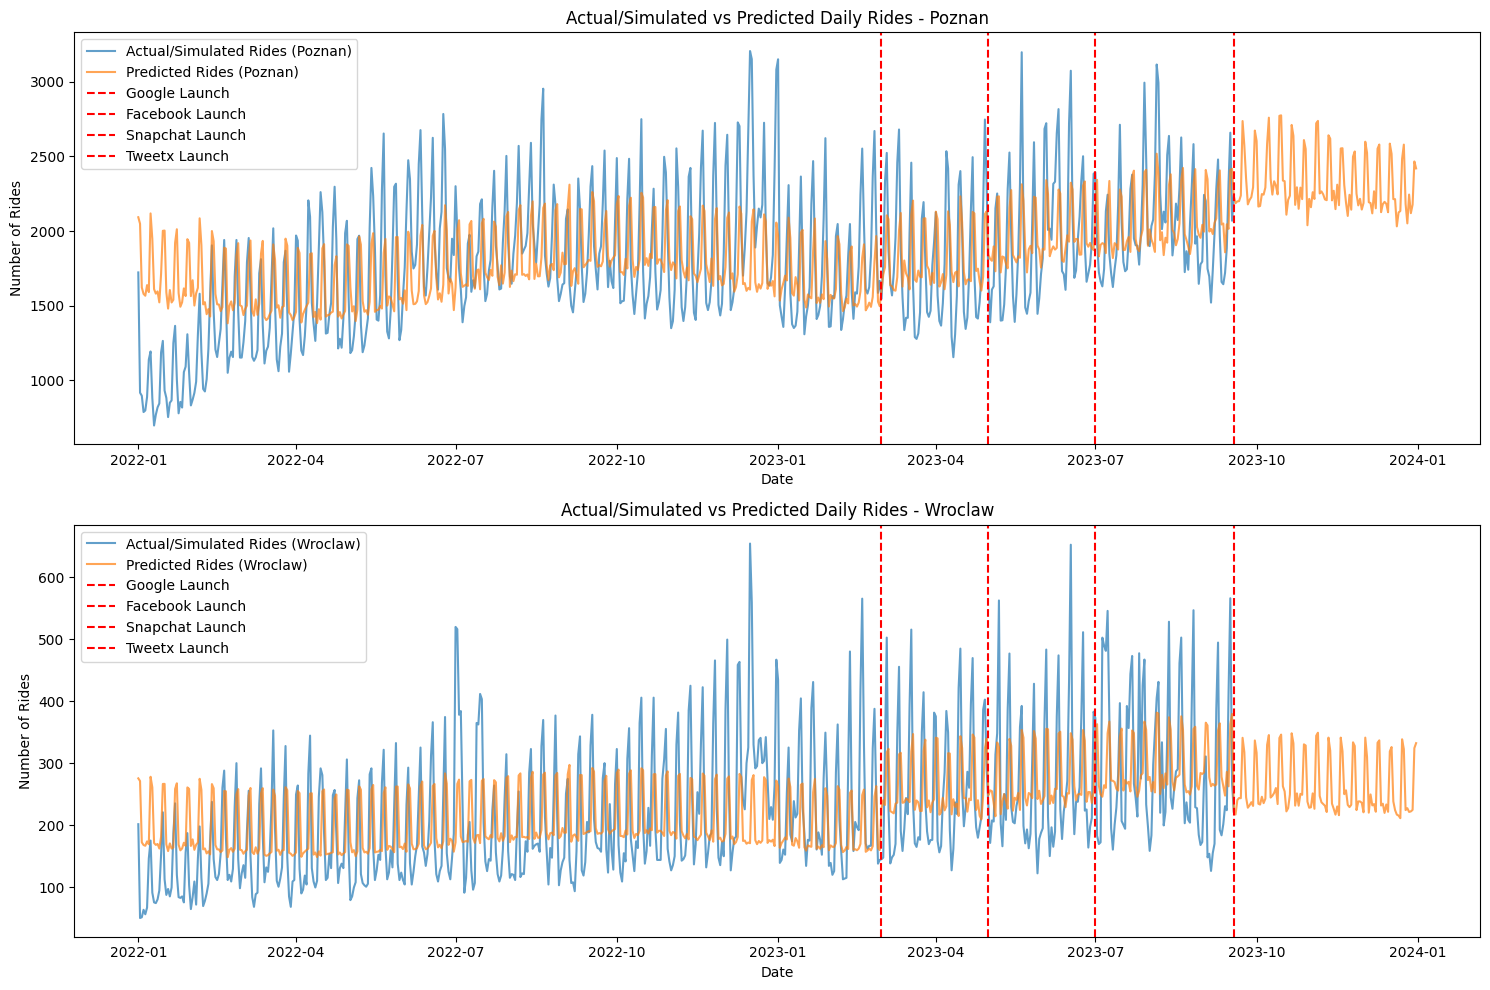


Marketing Channel Impacts for Poznan:
TweetX:
  Total Spend: €8,676
  Estimated Impact: 25,524 additional rides
  ROI: 2.94
Snapchat:
  Total Spend: €15,425
  Estimated Impact: 0 additional rides
  ROI: 0.00
Facebook:
  Total Spend: €20,394
  Estimated Impact: 18,913 additional rides
  ROI: 0.93
Google Ads:
  Total Spend: €25,375
  Estimated Impact: 70,741 additional rides
  ROI: 2.79

Estimated TweetX Impact per €1000 spent in Poznan: 2942 additional rides

Optimal Budget Allocation for Poznan:
TweetX: €25,513
Snapchat: €6,987
Facebook: €12,827
Google Ads: €24,543

Marketing Channel Impacts for Wroclaw:
TweetX:
  Total Spend: €8,891
  Estimated Impact: -0 additional rides
  ROI: 0.00
Snapchat:
  Total Spend: €15,336
  Estimated Impact: 978 additional rides
  ROI: 0.06
Facebook:
  Total Spend: €20,300
  Estimated Impact: 633 additional rides
  ROI: 0.03
Google Ads:
  Total Spend: €25,507
  Estimated Impact: 23,375 additional rides
  ROI: 0.92

Estimated TweetX Impact per €1000 spent i

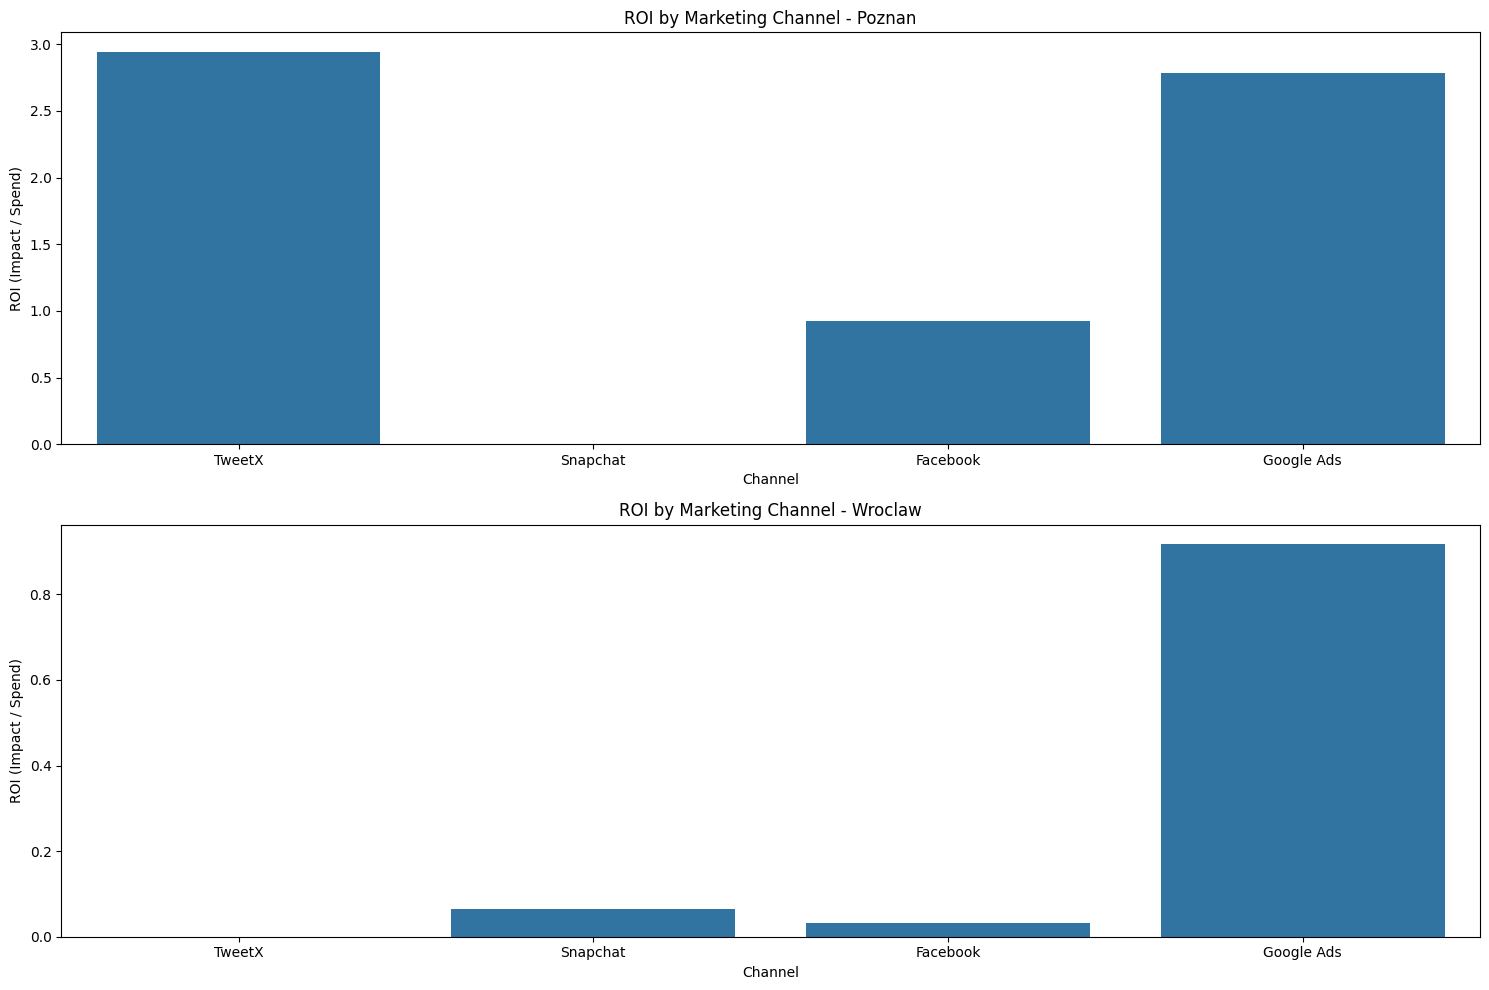

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.optimize import minimize

# get the data fromt the csv file
df = pd.read_csv(r'C:\Users\kaczm\Desktop\Bolt Marketing\Test Task - Marketing Measurement - DF.csv')
df['date'] = pd.to_datetime(df['date'])
campaign_start = '2023-09-18'
cities = ['Poznan', 'Wroclaw']
df_cities = df[['date'] + cities]


# a function that predict future rides for a given city
def predict_future_city(city_data, steps):
    decomposition = seasonal_decompose(city_data, model='additive', period=7)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    trend_change = np.mean(np.diff(trend.dropna()))
    future_trend = np.arange(1, steps+1) * trend_change + trend.iloc[-1]
    future_seasonal = np.tile(seasonal[-7:], (steps // 7) + 1)[:steps]
    return future_trend + future_seasonal

#  future rides for each city
last_date = df['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), end='2023-12-31')
steps = len(future_dates)

df_future = pd.DataFrame({'date': future_dates})
for city in cities:
    future_rides = predict_future_city(df_cities[city], steps)
    df_future[city] = future_rides

df_combined = pd.concat([df_cities, df_future]).reset_index(drop=True)

# synthetic data with staggered start dates
np.random.seed(42)
channel_start_dates = {
    'google': '2023-03-01',
    'facebook': '2023-05-01',
    'snapchat': '2023-07-01',
    'tweetx': '2023-09-18'
}

for city in cities:
    for channel, start_date in channel_start_dates.items():
        column_name = f'{city}_{channel}_spend'
        df_combined[column_name] = np.where(df_combined['date'] >= start_date, 
                                            np.random.uniform(2000, 3000, len(df_combined)) / 30, 0)

# some additional features for the model to make it more interesting and realistic
df_combined['temperature'] = 20 + 10 * np.sin(np.arange(len(df_combined)) * 2 * np.pi / 365) + np.random.normal(0, 3, len(df_combined))
df_combined['is_weekend'] = (df_combined['date'].dt.dayofweek >= 5).astype(int)

# now simulate campaign effects 
for city in cities:
    base_effect = df_combined[city].mean() * 0.05
    for channel, start_date in channel_start_dates.items():
        channel_mask = df_combined['date'] >= start_date
        channel_effect = np.random.normal(base_effect * 0.5, base_effect * 0.1, len(df_combined))
        df_combined.loc[channel_mask, city] += channel_effect[channel_mask]
        
        # additional boost for TweetX for my needs 
        if channel == 'tweetx':
            tweetx_boost = df_combined.loc[channel_mask, city].mean() * 0.15  # 15% boost when TweetX launches
            df_combined.loc[channel_mask, city] += tweetx_boost

def constrained_ols(formula, data):
    model = ols(formula, data).fit()
    
    def obj_func(params):
        return -model.llf  
    
    spend_vars = [var for var in model.params.index if 'spend' in var]
    constraints = [{'type': 'ineq', 'fun': lambda params, i=i: params[i]} for i, var in enumerate(model.params.index) if var in spend_vars]
    
    initial = model.params.values
    result = minimize(obj_func, initial, method='SLSQP', constraints=constraints)
    
    constrained_model = ols(formula, data).fit()
    constrained_model.params = pd.Series(result.x, index=model.params.index)
    
    return constrained_model

models = {}
for city in cities:
    formula = f"{city} ~ {city}_tweetx_spend + {city}_snapchat_spend + {city}_facebook_spend + {city}_google_spend + temperature + is_weekend"
    models[city] = constrained_ols(formula, df_combined)
    print(f"\nModel summary for {city}:")
    print(models[city].params)

# visualize
plt.figure(figsize=(15, 10))
for i, city in enumerate(cities, 1):
    plt.subplot(2, 1, i)
    df_combined[f'{city}_predicted'] = models[city].predict(df_combined)
    plt.plot(df_combined['date'], df_combined[city], label=f'Actual/Simulated Rides ({city})', alpha=0.7)
    plt.plot(df_combined['date'], df_combined[f'{city}_predicted'], label=f'Predicted Rides ({city})', alpha=0.7)
    for channel, start_date in channel_start_dates.items():
        plt.axvline(x=pd.to_datetime(start_date), color='r', linestyle='--', label=f'{channel.capitalize()} Launch')
    plt.legend()
    plt.title(f'Actual/Simulated vs Predicted Daily Rides - {city}')
    plt.xlabel('Date')
    plt.ylabel('Number of Rides')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, city in enumerate(cities, 1):
    plt.subplot(2, 1, i)
    impact_data = pd.DataFrame({
        'Channel': ['TweetX', 'Snapchat', 'Facebook', 'Google Ads'],
        'Impact': [
            models[city].params[f'{city}_tweetx_spend'] * df_combined[f'{city}_tweetx_spend'].sum(),
            models[city].params[f'{city}_snapchat_spend'] * df_combined[f'{city}_snapchat_spend'].sum(),
            models[city].params[f'{city}_facebook_spend'] * df_combined[f'{city}_facebook_spend'].sum(),
            models[city].params[f'{city}_google_spend'] * df_combined[f'{city}_google_spend'].sum()
        ],
        'Spend': [
            df_combined[f'{city}_tweetx_spend'].sum(),
            df_combined[f'{city}_snapchat_spend'].sum(),
            df_combined[f'{city}_facebook_spend'].sum(),
            df_combined[f'{city}_google_spend'].sum()
        ]
    })
    impact_data['ROI'] = impact_data['Impact'] / impact_data['Spend']
    impact_data['ROI'] = np.maximum(impact_data['ROI'], 0)
    
    sns.barplot(x='Channel', y='ROI', data=impact_data)
    plt.title(f'ROI by Marketing Channel - {city}')
    plt.ylabel('ROI (Impact / Spend)')
    
    print(f"\nMarketing Channel Impacts for {city}:")
    for _, row in impact_data.iterrows():
        print(f"{row['Channel']}:")
        print(f"  Total Spend: €{row['Spend']:,.0f}")
        print(f"  Estimated Impact: {row['Impact']:,.0f} additional rides")
        print(f"  ROI: {row['ROI']:.2f}")
    
    print(f"\nEstimated TweetX Impact per €1000 spent in {city}: {models[city].params[f'{city}_tweetx_spend'] * 1000:.0f} additional rides")

    total_budget = impact_data['Spend'].sum()
    min_budget = total_budget * 0.1
    remaining_budget = total_budget - min_budget * len(impact_data)
    
    positive_roi_sum = impact_data['ROI'][impact_data['ROI'] > 0].sum()
    if positive_roi_sum > 0:
        optimal_allocation = min_budget + (impact_data['ROI'] / positive_roi_sum * remaining_budget)
    else:
        optimal_allocation = [total_budget / len(impact_data)] * len(impact_data)
    
    print(f"\nOptimal Budget Allocation for {city}:")
    for channel, optimal_spend in zip(impact_data['Channel'], optimal_allocation):
        print(f"{channel}: €{optimal_spend:,.0f}")

plt.tight_layout()
plt.show()

# Now this is just an example - real life data would look completely different. Yet MMM could be the right choice as a measurement framework in an environment that uses lots of channels